# Various statistics in main text

In [1]:
from fuc import pymaf, common

mf = pymaf.MafFrame.from_file('./data/final.maf')
mf.df['PatientID'] = [x.split('_')[0] for x in mf.df.Tumor_Sample_Barcode]
mf.df['SampleType'] = [x.split('_')[1] for x in mf.df.Tumor_Sample_Barcode]
mf.df['Clonality'] = mf.compute_clonality('AF')

af = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')

n_patients = af.df.StudyID.nunique()
n_mutations = mf.shape[0]

t_df = mf.df[mf.df.SampleType == 'T']
b_df = mf.df[mf.df.SampleType == 'B']
p_df = mf.df[mf.df.SampleType == 'P']

print('< # of observed mutations >')
print(mf.shape[0])
print()
print('< # of unique mutations >')
print(mf.df[~mf.df.duplicated(['Hugo_Symbol', 'Protein_Change'])].shape[0])
print()
print('< # of genes >')
print(mf.df.Hugo_Symbol.nunique())
print()
print('< # of mutations in tissue >')
print(t_df.shape[0])
print()
print('< # of mutations in baseline >')
print(b_df.shape[0])
print()
print('< # of mutations in PD >')
print(p_df.shape[0])
print()
print('< Variant classifications >')
print(mf.df.Variant_Classification.value_counts())
print()
print('< Samples with no mutations at all >')
print([x for x in af.df.StudyID.unique() if x not in [x.split('_')[0] for x in mf.df.Tumor_Sample_Barcode]])
print()
print('< Mutational prevalence in APC >')
apc_df = mf.df[mf.df.Hugo_Symbol == 'APC']
print('Tissue:', round(apc_df[apc_df.SampleType == 'T'].PatientID.nunique() / af.df.StudyID.nunique() * 100, 1))
print('Baseline:', round(apc_df[apc_df.SampleType == 'B'].PatientID.nunique() / af.df.StudyID.nunique() * 100, 1))
print('PD:', round(apc_df[apc_df.SampleType == 'P'].PatientID.nunique() / af.df.StudyID.nunique() * 100, 1))
print()
print('< # of samples who benifited by sequencing baseline-ctDNA >')
patients = []
for patient in af.df.StudyID.unique():
    for gene in mf.df.Hugo_Symbol.unique():
        df = mf.df[(mf.df.PatientID == patient) & (mf.df.Hugo_Symbol == gene)]
        for mutation in df.Protein_Change.unique():
            l = df[df.Protein_Change == mutation].SampleType.to_list()
            if 'T' not in l and 'B' in l:
                patients.append(patient)
print(len(set(patients)), round(len(set(patients)) / n_patients * 100, 1))
print()
print('< # of samples who benifited by sequencing both baseline- and PD-ctDNA >')
patients = []
for patient in af.df.StudyID.unique():
    for gene in mf.df.Hugo_Symbol.unique():
        df = mf.df[(mf.df.PatientID == patient) & (mf.df.Hugo_Symbol == gene)]
        for mutation in df.Protein_Change.unique():
            l = df[df.Protein_Change == mutation].SampleType.to_list()
            if 'T' not in l and ('B' in l or 'P' in l):
                patients.append(patient)
print(len(set(patients)), round(len(set(patients)) / n_patients * 100, 1))
print()
print('< # of patients who did not have any mutations in tDNA >')
print(n_patients - t_df.PatientID.nunique(), round((n_patients - t_df.PatientID.nunique()) / n_patients * 100, 1))
print()
print('< # of patients who did not have any mutations in baseline-ctDNA >')
print(n_patients - b_df.PatientID.nunique(), round((n_patients - b_df.PatientID.nunique()) / n_patients * 100, 1))
print()
print('< # of patients who did not have any mutations in PD-ctDNA >')
print(n_patients - p_df.PatientID.nunique(), round((n_patients - p_df.PatientID.nunique()) / n_patients * 100, 1))
print()
print('< # of subcloncal mutations >')
print(mf.df.Clonality.value_counts()['Subclonal'] , round(mf.df.Clonality.value_counts()['Subclonal'] / n_mutations * 100, 1))

< # of observed mutations >
504

< # of unique mutations >
202

< # of genes >
34

< # of mutations in tissue >
232

< # of mutations in baseline >
155

< # of mutations in PD >
117

< Variant classifications >
Missense_Mutation    272
Nonsense_Mutation    101
Frame_Shift_Del       68
Frame_Shift_Ins       50
Splice_Site           13
Name: Variant_Classification, dtype: int64

< Samples with no mutations at all >
['CRC168']

< Mutational prevalence in APC >
Tissue: 67.9
Baseline: 44.0
PD: 34.5

< # of samples who benifited by sequencing baseline-ctDNA >
32 38.1

< # of samples who benifited by sequencing both baseline- and PD-ctDNA >
40 47.6

< # of patients who did not have any mutations in tDNA >
4 4.8

< # of patients who did not have any mutations in baseline-ctDNA >
22 26.2

< # of patients who did not have any mutations in PD-ctDNA >
33 39.3

< # of subcloncal mutations >
20 4.0


# Figure 1. Overview of sample collection scheme and data analysis pipeline

![Overview](overview.png)

# Figure 2. Oncoplot of genomic alterations in colorectal cancer patients for the ten most commonly mutated genes

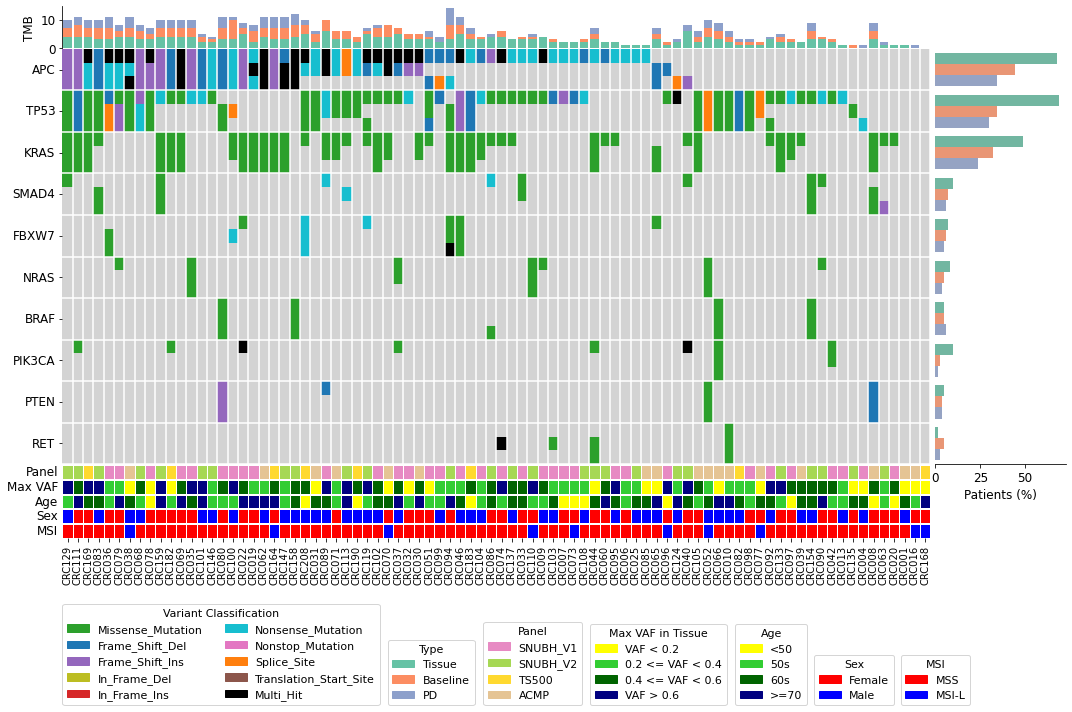

In [2]:
import matplotlib.pyplot as plt
from fuc import pymaf, common
import pandas as pd
import seaborn as sns

mf = pymaf.MafFrame.from_file('./data/final.maf')
af1 = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')
af2 = common.AnnFrame.from_file('./data/patient-annot.csv', sep=',', sample_col='StudyID')

figsize = (15, 10)
label_fontsize = 12
ticklabels_fontsize = 12
legend_fontsize = 11
patient_col = 'StudyID'
group_col = 'Type'
groups = ['Tissue', 'Baseline', 'PD']
colors = 'Set2'
seq_colors = ['yellow', 'limegreen', 'darkgreen', 'navy']

fig, axes = plt.subplots(8, 2, figsize=figsize, 
                         gridspec_kw={'height_ratios': [1, 10, 1/3, 1/3, 1/3, 1/3, 1/3, 4], 
                                      'width_ratios': [10, 1.5]})

[[ax1, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8], 
 [ax9, ax10], [ax11, ax12], [ax13, ax14], [ax15, ax16]] = axes

patients = mf.matrix_waterfall_matched(af1, patient_col, group_col, groups).columns


mf.plot_tmb_matched(af1, patient_col, group_col, group_order=groups, ax=ax1, legend=False, 
                    patients=patients, width=0.8, color=sns.color_palette(colors)[:3])
ax1.set_xticks([])
ax1.set_xlim(-0.5, len(patients)-0.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('TMB', fontsize=label_fontsize)
ax1.tick_params(axis='y', which='major',
                labelsize=ticklabels_fontsize)

ax2.remove()

mf.plot_waterfall_matched(af1, patient_col, group_col, group_order=groups, ax=ax3)
ax3.set_xticks([])
ax3.tick_params(axis='y', which='major', labelrotation=0,
                labelsize=ticklabels_fontsize)

mf.plot_mutated_matched(
    af1, patient_col, group_col, group_order=groups, ax=ax4, palette=colors
)
ax4.set_yticks([])
ax4.legend().remove()
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.tick_params(axis='x', which='major',
                labelsize=ticklabels_fontsize)
ax4.set_xlabel('Patients (%)', fontsize=label_fontsize)

ax5, handles3 = af2.plot_annot(
    'Panel', 
    group_order=['SNUBH_V1', 'SNUBH_V2', 'TS500', 'ACMP'],
    ax=ax5,
    samples=patients,
    xticklabels=False,
    colors=list(plt.get_cmap('Set2').colors[3:7])
)
ax5.set_ylabel('Panel', rotation='horizontal', ha='right', va='center', fontsize=12)

ax6.remove()

ax7, handles4 = af2.plot_annot(
    'MaxVAF',
    ax=ax7,
    samples=patients,
    group_order=['VAF < 0.2', '0.2 <= VAF < 0.4', '0.4 <= VAF < 0.6', 'VAF > 0.6'],
    colors=seq_colors,
    xticklabels=False,
    sequential=True
)
ax7.set_ylabel('Max VAF', rotation='horizontal', ha='right', va='center', fontsize=12)

ax8.remove()

ax9, handles6 = af2.plot_annot(
    'AgeGroup',
    ax=ax9,
    samples=patients,
    group_order=['<50', '50s', '60s', '>=70'],
    colors=seq_colors,
    xticklabels=False,
    sequential=True
)
ax9.set_ylabel('Age', rotation='horizontal', ha='right', va='center', fontsize=12)

ax10.remove()

ax11, handles5 = af2.plot_annot(
    'Sex',
    ax=ax11,
    samples=patients,
    group_order=['Female', 'Male'],
    xticklabels=False,
    colors=['red', 'blue']
)
ax11.set_ylabel('Sex', rotation='horizontal', ha='right', va='center', fontsize=12)

ax12.remove()

ax13, handles7 = af2.plot_annot(
    'MSI',
    ax=ax13,
    samples=patients,
    group_order=['MSS', 'MSI-L'],
    colors=['red', 'blue']
)
ax13.set_ylabel('MSI', rotation='horizontal', ha='right', va='center', fontsize=12)

ax14.remove()

# # Create the legends.
kwargs = dict(fontsize=legend_fontsize, title_fontsize=legend_fontsize)
handles1 = common.legend_handles(pymaf.NONSYN_NAMES+['Multi_Hit'], colors=pymaf.NONSYN_COLORS+['k'])
handles2 = common.legend_handles(groups, colors=colors)
leg1 = ax15.legend(handles=handles1, loc=(0, 0), title='Variant Classification', ncol=2, **kwargs)
leg2 = ax15.legend(handles=handles2, loc=(0.375, 0), title=group_col, **kwargs)
leg3 = ax15.legend(handles=handles3, loc=(0.485, 0), title='Panel', **kwargs)
leg4 = ax15.legend(handles=handles4, loc=(0.608, 0), title='Max VAF in Tissue', **kwargs)
leg5 = ax15.legend(handles=handles6, loc=(0.775, 0), title='Age', **kwargs)
leg6 = ax15.legend(handles=handles5, loc=(0.866, 0), title='Sex', **kwargs)
leg7 = ax15.legend(handles=handles7, loc=(0.966, 0), title='MSI', **kwargs)

ax15.add_artist(leg1)
ax15.add_artist(leg2)
ax15.add_artist(leg3)
ax15.add_artist(leg4)
ax15.add_artist(leg5)
ax15.add_artist(leg6)
ax15.axis('off')

# Remove the bottom right plot.
ax16.remove()

plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('./outputs/oncoplot.png')

# Figure 3. Correlation analysis results from pairwise comparisons between DNA sample types

Results for Baseline ~ Tissue:
R^2 = 0.96
  P = 7.84e-07
Results for PD ~ Tissue:
R^2 = 0.97
  P = 2.08e-07
Results for PD ~ Baseline:
R^2 = 0.99
  P = 4.61e-09
Results for Baseline ~ Tissue:
R^2 = 0.24
  P = 2.02e-06
Results for PD ~ Tissue:
R^2 = 0.16
  P = 1.48e-04
Results for PD ~ Baseline:
R^2 = 0.40
  P = 8.21e-11


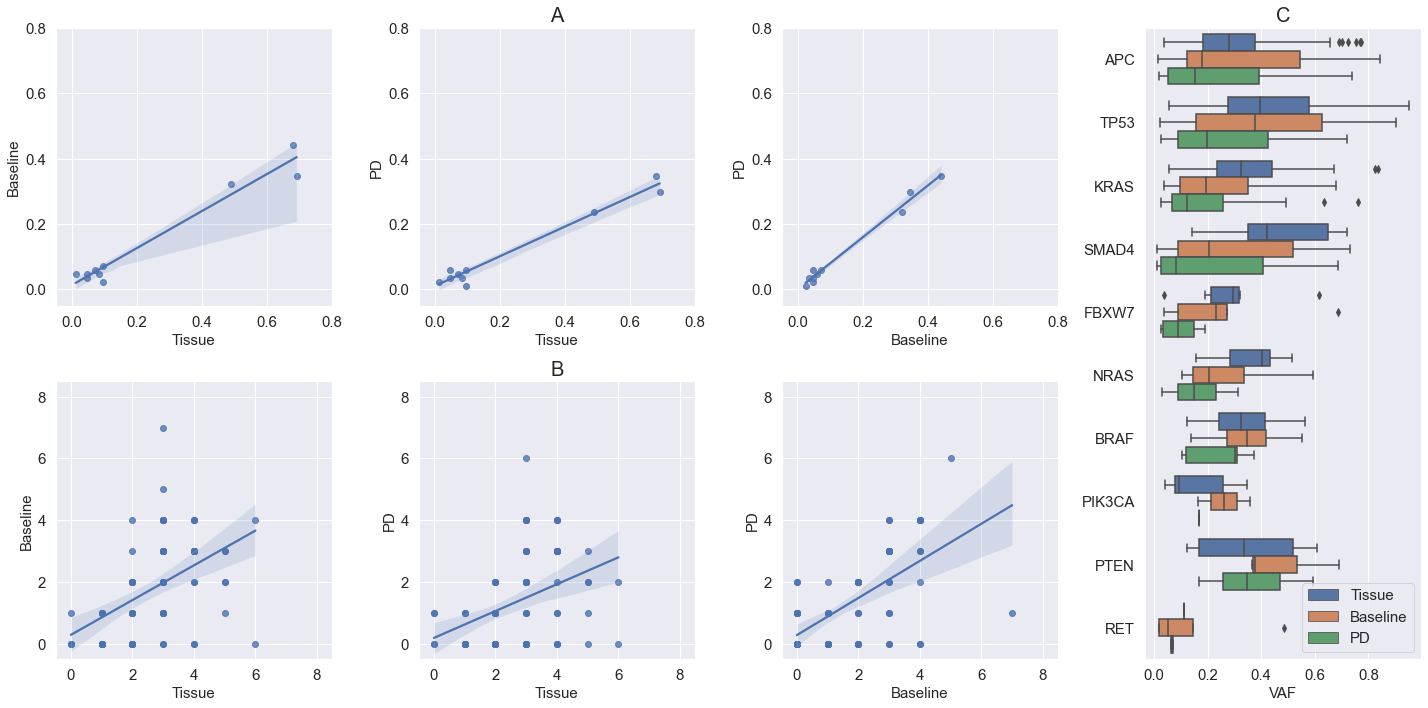

In [3]:
import matplotlib.pyplot as plt
from fuc import pymaf, pyvcf, common
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()

mf = pymaf.MafFrame.from_file('./data/final.maf')
af = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

[[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = axes

gs = axes[0, 3].get_gridspec()

# remove the underlying axes
for ax in axes[:, 3]:
    ax.remove()
    
axbig = fig.add_subplot(gs[:, 3])

n = 84

mf.plot_regplot_gene(af, 'Type', 'Tissue', 'Baseline', ax=ax1, a_size=n, b_size=n, to_csv='./data/correlations-baseline_tissue.csv')
mf.plot_regplot_gene(af, 'Type', 'Tissue', 'PD', ax=ax2, a_size=n, b_size=n, to_csv='./data/correlations-tissue_pd.csv')
mf.plot_regplot_gene(af, 'Type', 'Baseline', 'PD', ax=ax3, a_size=n, b_size=n, to_csv='./data/correlations-baseline_pd.csv')

mf.plot_regplot_tmb(af, 'StudyID', 'Type', 'Tissue', 'Baseline', ax=ax5, to_csv='./data/tmb-baseline_tissue.csv')
mf.plot_regplot_tmb(af, 'StudyID', 'Type', 'Tissue', 'PD', ax=ax6, to_csv='./data/tmb-tissue_pd.csv')
mf.plot_regplot_tmb(af, 'StudyID', 'Type', 'Baseline', 'PD', ax=ax7, to_csv='./data/tmb-baseline_pd.csv')

mf.plot_vaf('AF', group_col='Type', group_order=['Tissue', 'Baseline', 'PD'], af=af, ax=axbig, sort=False, flip=True)

for i, ax in enumerate([ax1, ax2, ax3, ax5, ax6, ax7]):
    if i < 3:
        ax.set_xlim([-0.05, 0.8])
        ax.set_ylim([-0.05, 0.8])
        ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
    else:
        ax.set_xlim([-0.5, 8.5])
        ax.set_ylim([-0.5, 8.5])
        ax.set_yticks([0, 2, 4, 6, 8])

    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)

    ax.tick_params(axis='both', which='major', labelsize=15)

axbig.xaxis.label.set_size(15)
axbig.tick_params(axis='both', which='major', labelsize=15)
axbig.legend(fontsize=15)

ax2.set_title('A', fontsize=20)
ax6.set_title('B', fontsize=20)
axbig.set_title('C', fontsize=20)

plt.tight_layout()
plt.savefig('./outputs/correlations.png')

In [4]:
import matplotlib
matplotlib.rc_file_defaults()

# Figure 4. Analysis of gene-gene interaction in colorectal cancer patients

Results for APC ~ KRAS:
R^2 = 0.05
  P = 9.49e-03
Results for TP53 ~ KRAS:
R^2 = 0.00
  P = 4.18e-01
Results for BRAF ~ KRAS:
R^2 = 0.17
  P = 1.49e-05
Results for NRAS ~ KRAS:
R^2 = 0.17
  P = 1.46e-05


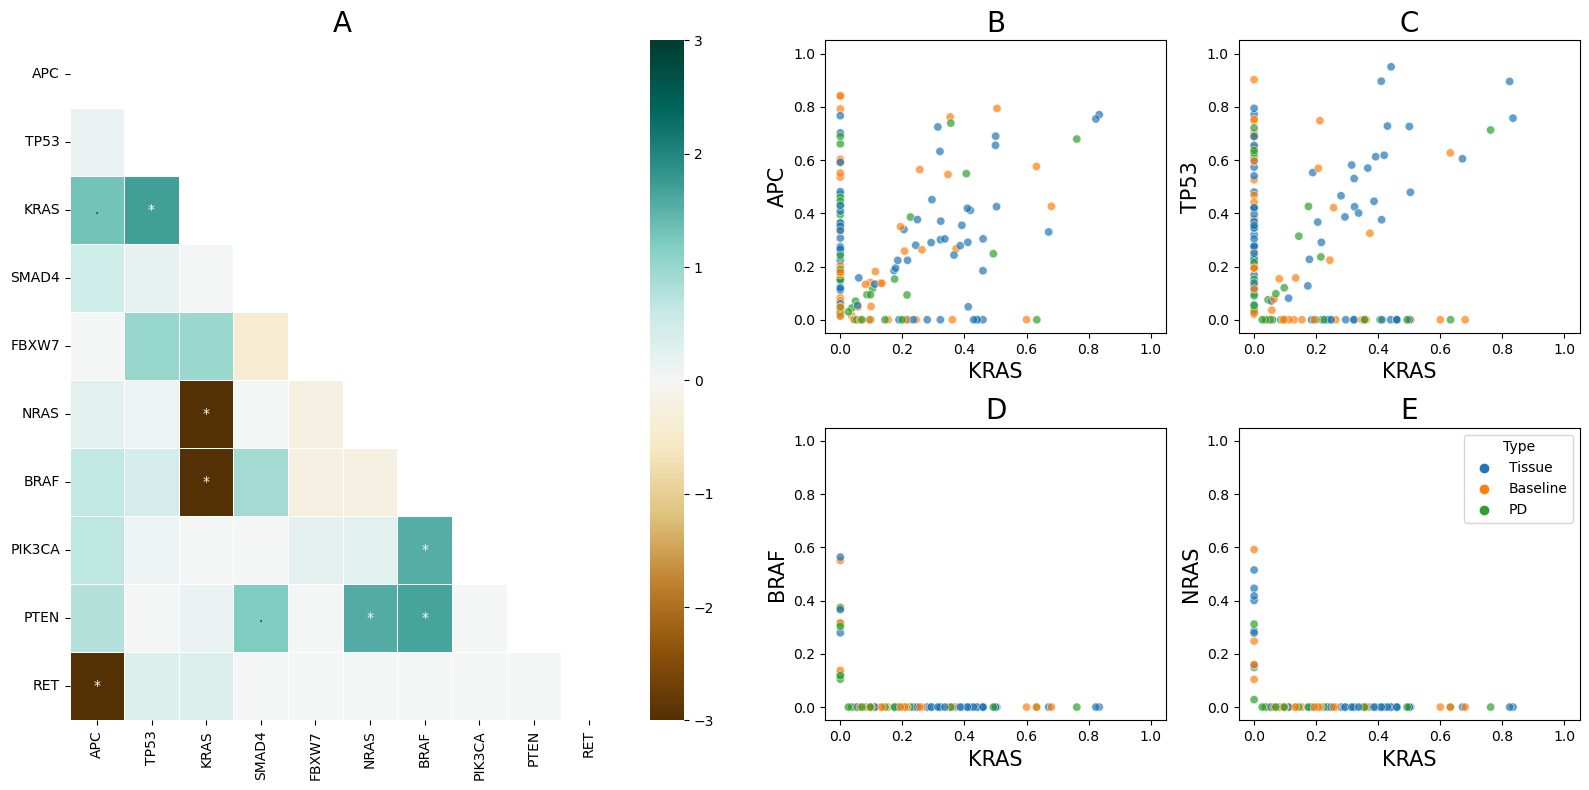

In [5]:
import matplotlib.pyplot as plt
from fuc import pymaf, common
import seaborn as sns
import pandas as pd

mf = pymaf.MafFrame.from_file('./data/final.maf')
af = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')

fig, axes = plt.subplots(2, 3, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 0.5, 0.5]})

gs = axes[0, 0].get_gridspec()

axes[0, 0].remove()
axes[1, 0].remove()
axbig = fig.add_subplot(gs[:, 0])

mf.plot_interactions(cmap='BrBG', linewidths=0.5, ax=axbig)

for ticklabel in axbig.get_yticklabels():
    ticklabel.set_rotation(0)

mf.plot_genepair('KRAS', 'APC', 'AF', af=af, group_col='Type', ax=axes[0, 1], group_order=['Tissue', 'Baseline', 'PD'], alpha=0.7)
mf.plot_genepair('KRAS', 'TP53', 'AF', af=af, group_col='Type', ax=axes[0, 2], group_order=['Tissue', 'Baseline', 'PD'], alpha=0.7)
mf.plot_genepair('KRAS', 'BRAF', 'AF', af=af, group_col='Type', ax=axes[1, 1], group_order=['Tissue', 'Baseline', 'PD'], alpha=0.7)
mf.plot_genepair('KRAS', 'NRAS', 'AF', af=af, group_col='Type', ax=axes[1, 2], group_order=['Tissue', 'Baseline', 'PD'], alpha=0.7)

ax_list = [axbig, axes[0, 1], axes[0, 2], axes[1, 1], axes[1, 2]]
titles = ['A', 'B', 'C', 'D', 'E']

for i, ax in enumerate(ax_list):
    ax.set_title(titles[i], fontsize=20)
    if i in [1, 2, 3]:
        ax.legend().remove()
    if i in [1, 2, 3, 4]:
        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-0.05, 1.05])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./outputs/interactions.png')

# Figure 5. Representative examples of cancer evolution dynamics.

<ipython-input-6-84b7a6aefdd2>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Tissue', 'Baseline', 'PD'])
<ipython-input-6-84b7a6aefdd2>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Tissue', 'Baseline', 'PD'])
<ipython-input-6-84b7a6aefdd2>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Tissue', 'Baseline', 'PD'])
<ipython-input-6-84b7a6aefdd2>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Tissue', 'Baseline', 'PD'])
<ipython-input-6-84b7a6aefdd2>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Tissue', 'Baseline', 'PD'])
<ipython-input-6-84b7a6aefdd2>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Tissue', 'Baseline', 'PD'])


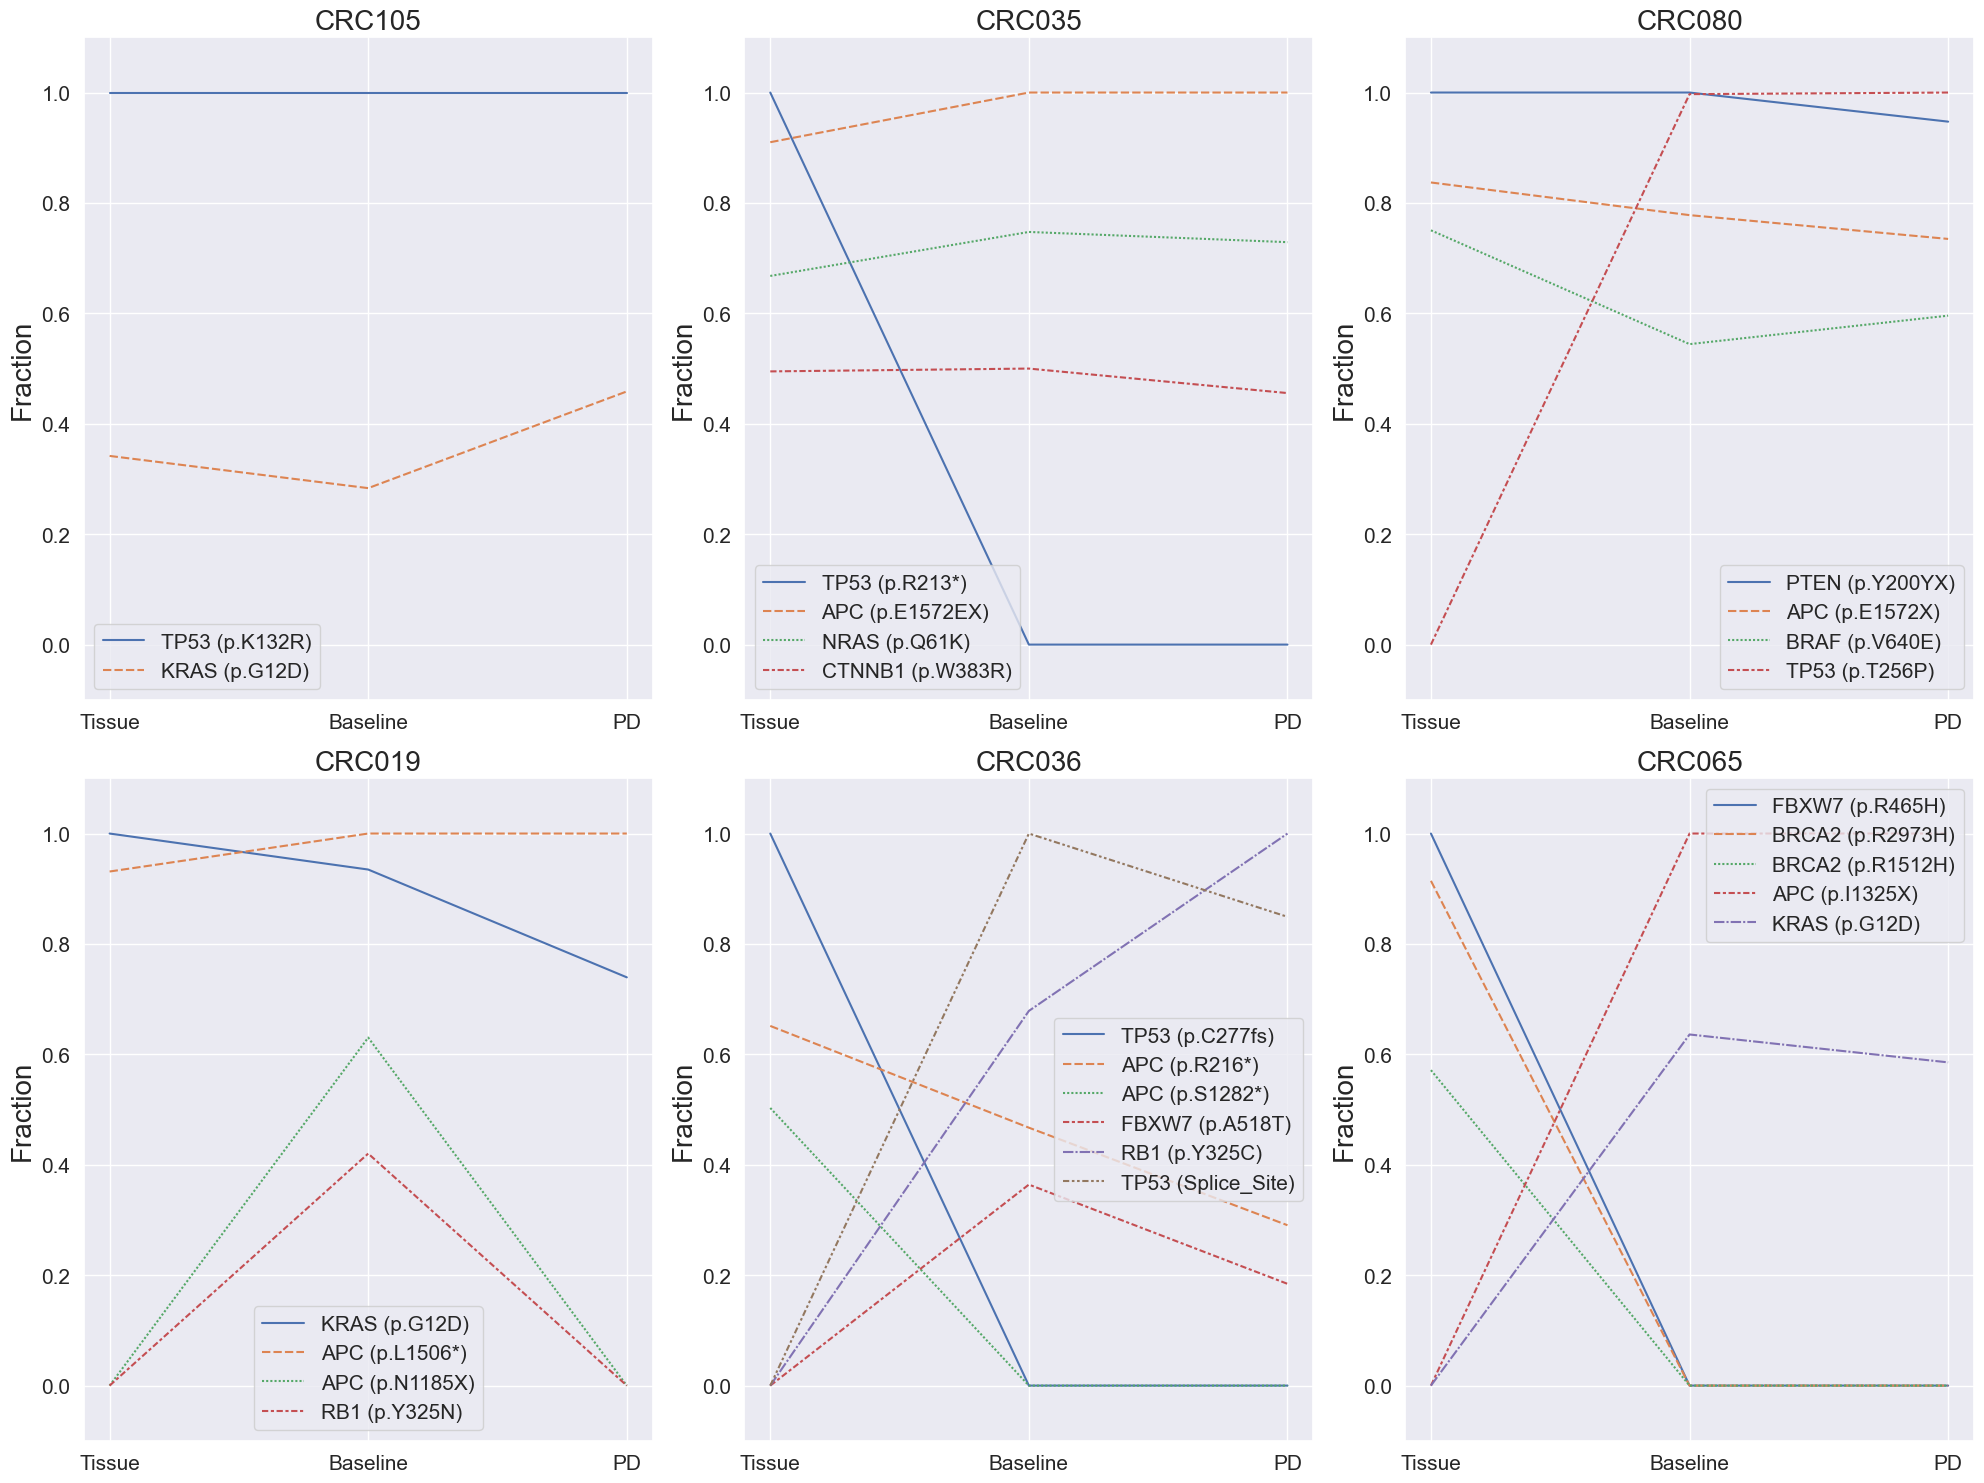

In [6]:
import matplotlib.pyplot as plt
from fuc import pymaf, common
import seaborn as sns
import pandas as pd

sns.set()

mf = pymaf.MafFrame.from_file('./data/final.maf')
af = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')
df = af.df.reset_index().pivot(index='StudyID', columns='Type', values='SampleID').reset_index()
d = {}

for i, r in df.iterrows():
    d[r.StudyID] = [r.Tissue, r.Baseline, r.PD]

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 15))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
patients = ['CRC105', 'CRC035', 'CRC080', 'CRC019', 'CRC036', 'CRC065']

for i, ax in enumerate(axes):
    mf.plot_evolution(d[patients[i]], 'AF', ax=ax, count=50)
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticklabels(['Tissue', 'Baseline', 'PD'])
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.yaxis.label.set_size(20)
    ax.set_title(patients[i], fontsize=20)
    ax.legend(fontsize=15)
    
plt.tight_layout()
plt.savefig('./outputs/evolution.png')

# Table 1. Gene concordance for the ten genes with the highest mutation prevalence

In [7]:
from fuc import pymaf, common
import pandas as pd

mf = pymaf.MafFrame.from_file('./data/final.maf')
af = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')
df = af.df.reset_index().pivot(index='StudyID', columns='Type', values='SampleID')

genes = ['APC', 'TP53', 'KRAS', 'SMAD4', 'FBXW7', 'BRAF', 'PTEN', 'NRAS', 'PIK3CA', 'RET']
conc = {}

for gene in genes:
    TB = []
    TP = []
    BP = []
    for i, r in df.iterrows():        
        TB.append(mf.get_gene_concordance(gene, r.Tissue, r.Baseline))
        TP.append(mf.get_gene_concordance(gene, r.Tissue, r.PD))
        BP.append(mf.get_gene_concordance(gene, r.Baseline, r.PD))
    conc[gene] = [sum(TB), sum(TP), sum(BP)]
    conc[gene] = [round(x/df.shape[0] * 100, 1) for x in conc[gene]]
    
df = pd.DataFrame(conc).T
df.index.name = 'Gene'
df.columns = ['TB', 'TP', 'BP']
df.to_csv('./outputs/gene-concordance.csv')

# Supplementary Figure 1. Lollipop plot for the ten most commonly mutated genes

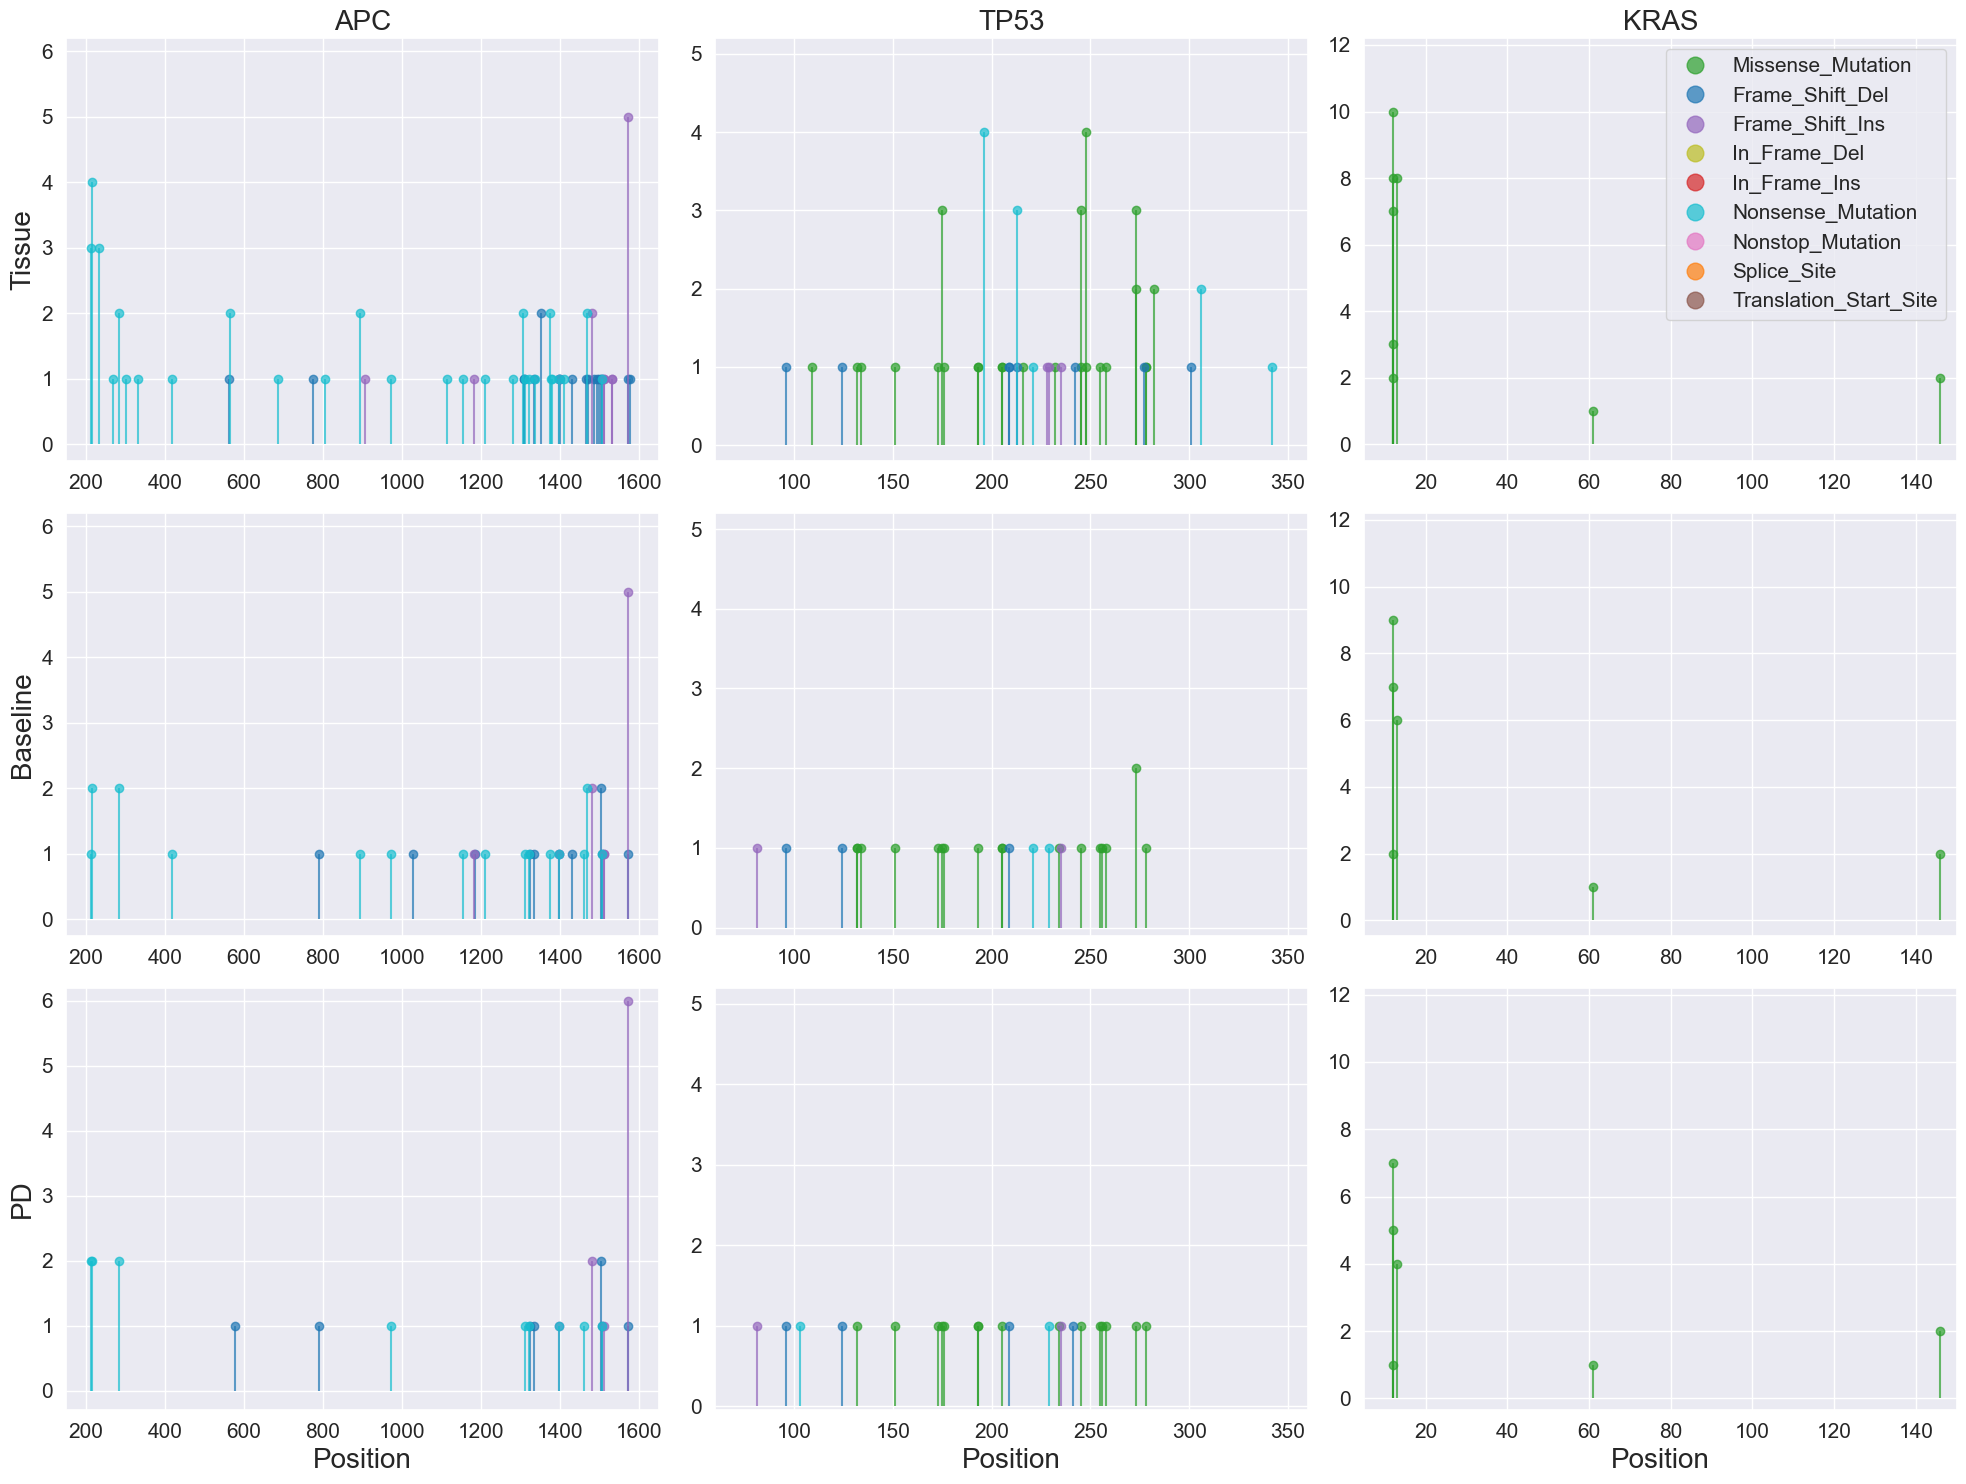

In [8]:
import matplotlib.pyplot as plt
from fuc import pymaf, common
import seaborn as sns

sns.set()

mf = pymaf.MafFrame.from_file('./data/final.maf')
af = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')

t_mf = mf.subset(af.df[af.df.Type == 'Tissue'].index.to_list())
b_mf = mf.subset(af.df[af.df.Type == 'Baseline'].index.to_list())
p_mf = mf.subset(af.df[af.df.Type == 'PD'].index.to_list())

fig, axes = plt.subplots(3, 3, figsize=(20, 15))

specimens = ['Tissue', 'Baseline', 'PD']
genes = ['APC', 'TP53', 'KRAS']
mfs = [t_mf, b_mf, p_mf]
xmin = [150, 60, 5]
xmax = [1650, 360, 150]
ymax = [6.2, 5.2, 12.2]

i = 0
j = 0

for row in axes:
    for col in row:
        mfs[i].plot_lollipop(genes[j], ax=col)
        if i == 0 and j == 2:
            col.legend(fontsize=15, markerscale=2)
        else:
            col.get_legend().remove()
        if i == 0:
            col.set_title(genes[j], fontsize=20)
        if j == 0:
            col.set_ylabel(specimens[i])
        else:
            col.set_ylabel('')
        if i != 2:
            col.set_xlabel('')
        else:
            col.xaxis.label.set_size(20)
        col.tick_params(axis='both', which='major', labelsize=15)
        col.yaxis.label.set_size(20)
        col.set_xlim(xmin=xmin[j], xmax=xmax[j])
        col.set_ylim(ymax=ymax[j])
        j += 1
    i += 1
    j = 0

plt.tight_layout()
plt.savefig('./outputs/lollipop.png')

In [9]:
import matplotlib
matplotlib.rc_file_defaults()

# Supplementary Figure 2. Oncoplot of genomic alterations in colorectal cancer patients for all 43 mutated genes

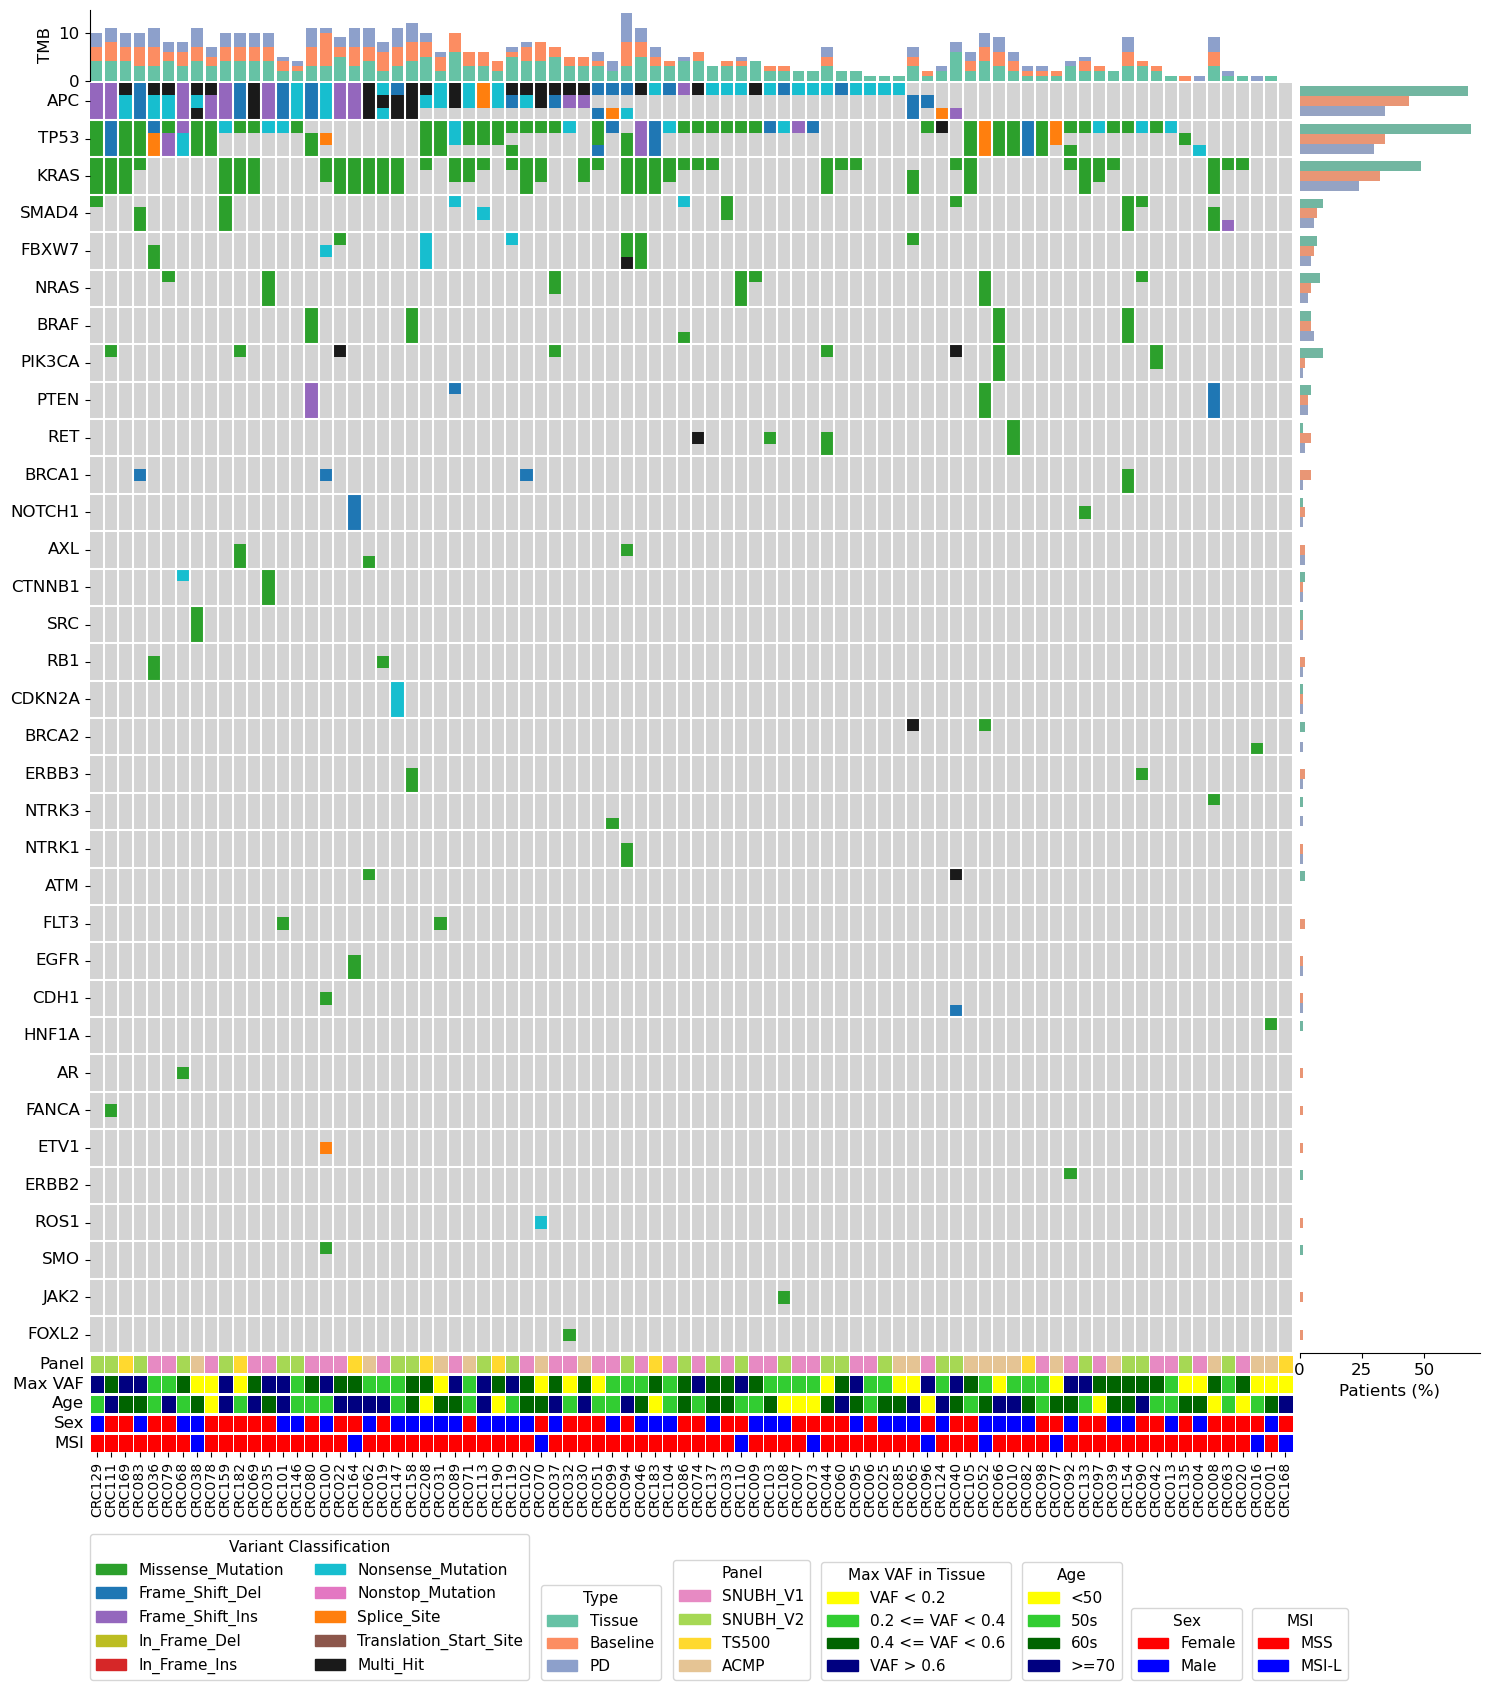

In [10]:
import matplotlib.pyplot as plt
from fuc import pymaf, common
import pandas as pd
import seaborn as sns

mf = pymaf.MafFrame.from_file('./data/final.maf')
af1 = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')
af2 = common.AnnFrame.from_file('./data/patient-annot.csv', sep=',', sample_col='StudyID')

figsize = (15, 17)
label_fontsize = 12
ticklabels_fontsize = 12
legend_fontsize = 11
count=100
patient_col = 'StudyID'
group_col = 'Type'
groups = ['Tissue', 'Baseline', 'PD']
colors = 'Set2'
seq_colors = ['yellow', 'limegreen', 'darkgreen', 'navy']

fig, axes = plt.subplots(8, 2, figsize=figsize, 
                         gridspec_kw={'height_ratios': [1, 18, 1/4, 1/4, 1/4, 1/4, 1/4, 3.2], 
                                      'width_ratios': [10, 1.5]})

[[ax1, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8], 
 [ax9, ax10], [ax11, ax12], [ax13, ax14], [ax15, ax16]] = axes

patients = mf.matrix_waterfall_matched(af1, patient_col, group_col, groups, count=count).columns


mf.plot_tmb_matched(af1, patient_col, group_col, group_order=groups, ax=ax1, legend=False, 
                    patients=patients, width=0.8, color=sns.color_palette(colors)[:3])
ax1.set_xticks([])
ax1.set_xlim(-0.5, len(patients)-0.5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_ylabel('TMB', fontsize=label_fontsize)
ax1.tick_params(axis='y', which='major',
                labelsize=ticklabels_fontsize)

ax2.remove()

mf.plot_waterfall_matched(af1, patient_col, group_col, group_order=groups, ax=ax3, count=count)
ax3.set_xticks([])
ax3.tick_params(axis='y', which='major', labelrotation=0,
                labelsize=ticklabels_fontsize)

mf.plot_mutated_matched(
    af1, patient_col, group_col, group_order=groups, ax=ax4, palette=colors, count=count
)
ax4.set_yticks([])
ax4.legend().remove()
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.tick_params(axis='x', which='major',
                labelsize=ticklabels_fontsize)
ax4.set_xlabel('Patients (%)', fontsize=label_fontsize)

ax5, handles3 = af2.plot_annot(
    'Panel', 
    group_order=['SNUBH_V1', 'SNUBH_V2', 'TS500', 'ACMP'],
    ax=ax5,
    samples=patients,
    xticklabels=False,
    colors=list(plt.get_cmap('Set2').colors[3:7])
)
ax5.set_ylabel('Panel', rotation='horizontal', ha='right', va='center', fontsize=12)

ax6.remove()

ax7, handles4 = af2.plot_annot(
    'MaxVAF',
    ax=ax7,
    samples=patients,
    group_order=['VAF < 0.2', '0.2 <= VAF < 0.4', '0.4 <= VAF < 0.6', 'VAF > 0.6'],
    colors=seq_colors,
    xticklabels=False,
    sequential=True
)
ax7.set_ylabel('Max VAF', rotation='horizontal', ha='right', va='center', fontsize=12)

ax8.remove()

ax9, handles6 = af2.plot_annot(
    'AgeGroup',
    ax=ax9,
    samples=patients,
    group_order=['<50', '50s', '60s', '>=70'],
    colors=seq_colors,
    xticklabels=False,
    sequential=True
)
ax9.set_ylabel('Age', rotation='horizontal', ha='right', va='center', fontsize=12)

ax10.remove()

ax11, handles5 = af2.plot_annot(
    'Sex',
    ax=ax11,
    samples=patients,
    group_order=['Female', 'Male'],
    xticklabels=False,
    colors=['red', 'blue']
)
ax11.set_ylabel('Sex', rotation='horizontal', ha='right', va='center', fontsize=12)

ax12.remove()

ax13, handles7 = af2.plot_annot(
    'MSI',
    ax=ax13,
    samples=patients,
    group_order=['MSS', 'MSI-L'],
    colors=['red', 'blue']
)
ax13.set_ylabel('MSI', rotation='horizontal', ha='right', va='center', fontsize=12)

ax14.remove()

# # Create the legends.
kwargs = dict(fontsize=legend_fontsize, title_fontsize=legend_fontsize)
handles1 = common.legend_handles(pymaf.NONSYN_NAMES+['Multi_Hit'], colors=pymaf.NONSYN_COLORS+['k'])
handles2 = common.legend_handles(groups, colors=colors)
leg1 = ax15.legend(handles=handles1, loc=(0, 0), title='Variant Classification', ncol=2, **kwargs)
leg2 = ax15.legend(handles=handles2, loc=(0.375, 0), title=group_col, **kwargs)
leg3 = ax15.legend(handles=handles3, loc=(0.485, 0), title='Panel', **kwargs)
leg4 = ax15.legend(handles=handles4, loc=(0.608, 0), title='Max VAF in Tissue', **kwargs)
leg5 = ax15.legend(handles=handles6, loc=(0.775, 0), title='Age', **kwargs)
leg6 = ax15.legend(handles=handles5, loc=(0.866, 0), title='Sex', **kwargs)
leg7 = ax15.legend(handles=handles7, loc=(0.966, 0), title='MSI', **kwargs)

ax15.add_artist(leg1)
ax15.add_artist(leg2)
ax15.add_artist(leg3)
ax15.add_artist(leg4)
ax15.add_artist(leg5)
ax15.add_artist(leg6)
ax15.axis('off')

# Remove the bottom right plot.
ax16.remove()

plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('./outputs/oncoplot-all.png')

# Supplementary Figure 3. Weak gene-gene interactions

Results for BRAF ~ PTEN:
R^2 = 0.02
  P = 5.87e-01
Results for NRAS ~ PTEN:
R^2 = 0.44
  P = 1.07e-03
Results for BRAF ~ PIK3CA:
R^2 = 0.04
  P = 3.74e-01
Results for RET ~ APC:
R^2 = 0.04
  P = 1.90e-02


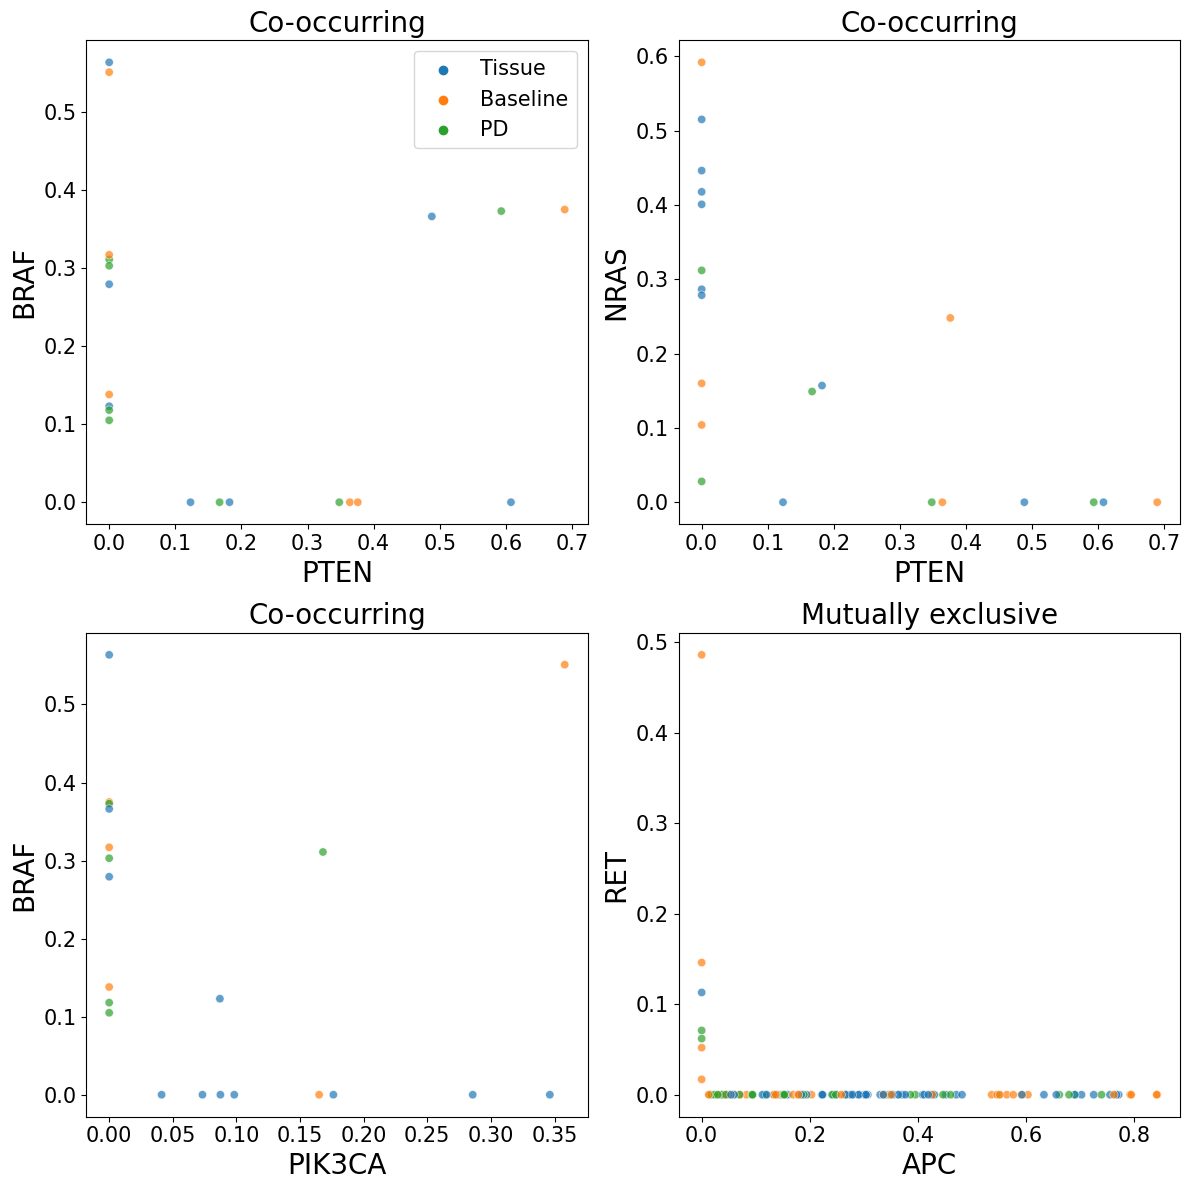

In [11]:
import matplotlib.pyplot as plt
from fuc import pymaf, common
import seaborn as sns
import pandas as pd

mf = pymaf.MafFrame.from_file('./data/final.maf')
af = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12, 12))

mf.plot_genepair('PTEN', 'BRAF', 'AF', af=af, group_col='Type', ax=ax1, group_order=['Tissue', 'Baseline', 'PD'], alpha=0.7)
mf.plot_genepair('PTEN', 'NRAS', 'AF', af=af, group_col='Type', ax=ax2, group_order=['Tissue', 'Baseline', 'PD'], alpha=0.7)
mf.plot_genepair('PIK3CA', 'BRAF', 'AF', af=af, group_col='Type', ax=ax3, group_order=['Tissue', 'Baseline', 'PD'], alpha=0.7)
mf.plot_genepair('APC', 'RET', 'AF', af=af, group_col='Type', ax=ax4, group_order=['Tissue', 'Baseline', 'PD'], alpha=0.7)

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    if i == 0:
        ax.legend(fontsize=15)
    else:
        ax.legend().remove()
    if i == 3:
        ax.set_title('Mutually exclusive', fontsize=20)
    else:
        ax.set_title('Co-occurring', fontsize=20)

plt.tight_layout()
plt.savefig('./outputs/interactions-spurious.png')

# Supplementary Figure 4. Identification of subclonal mutations using different thresholds

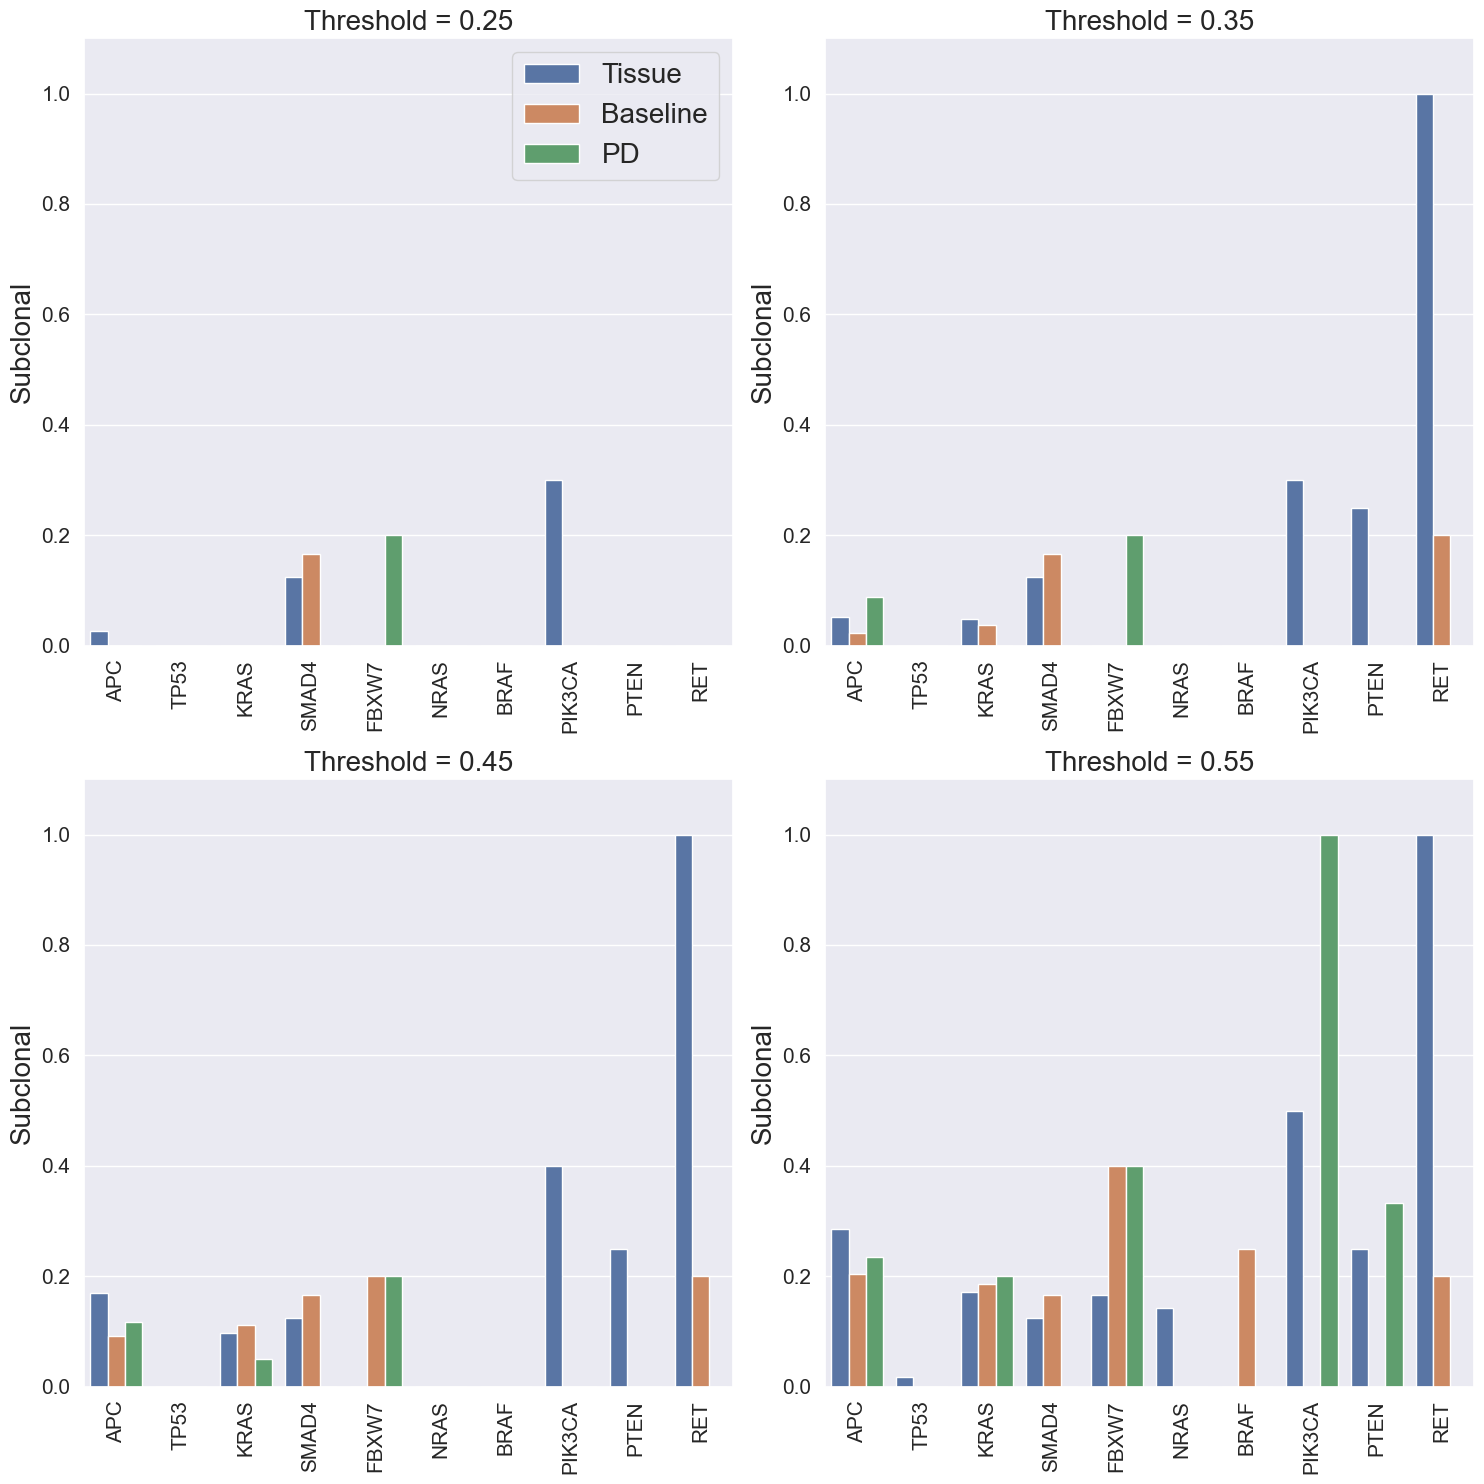

In [12]:
import matplotlib.pyplot as plt
from fuc import pymaf, common
import seaborn as sns

sns.set()

mf = pymaf.MafFrame.from_file('./data/final.maf')
af = common.AnnFrame.from_file('./data/sample-annot.csv', sep=',', sample_col='SampleID')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15, 15))

axes = [ax1, ax2, ax3, ax4]
thresholds = [0.25, 0.35, 0.45, 0.55]

for i, threshold in enumerate(thresholds):
    mf.plot_clonality('AF',
                      group_col='Type',
                      group_order=['Tissue', 'Baseline', 'PD'],
                      af=af, ax=axes[i],
                      subclonal=True,
                      threshold=threshold)
    if i == 0:
        axes[i].legend(fontsize=20)
    else:
        axes[i].get_legend().remove()
        
    axes[i].set_ylim([0, 1.1])
    axes[i].set_title(f'Threshold = {threshold}', fontsize=20)
    axes[i].tick_params(axis='both', which='major', labelsize=15)
    for ticklabel in axes[i].get_xticklabels():
        ticklabel.set_rotation(90)

    axes[i].xaxis.label.set_size(20)
    axes[i].yaxis.label.set_size(20)
    
plt.tight_layout()
plt.savefig('./outputs/subclone.png')

# Supplementary Table 1. Comparison of targeted panels

In [13]:
import pandas as pd

genes = {}
panels = ['ACP1', 'ACMP', 'SNUBH_V1', 'SNUBH_V2', 'TS500']
files = ['acp1.list', 'acmp.list', 'snubh-v1.list', 'snubh-v2.list', 'ts500.list']

for i, file in enumerate(files):
    n = 0
    with open(f'./panels/{file}') as f:
        for line in f:
            n += 1
            gene = line.strip()
            if gene not in genes:
                genes[gene] = ['X'] * 5
            genes[gene][i] = 'O'
    print(panels[i], n)

df = pd.DataFrame(genes).T
df.index.name = 'Gene'
df.columns = panels
df.to_csv('./outputs/panel-comparison.csv')

ACP1 88
ACMP 558
SNUBH_V1 99
SNUBH_V2 559
TS500 523
